SOM Model (unsupervised) for Fraud Detection

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


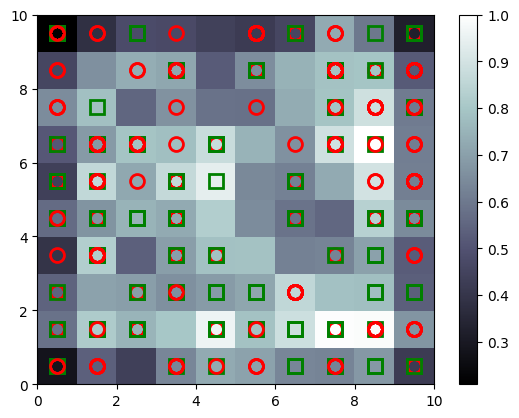

[[7 1]
 [8 1]
 [8 6]]
[15712877. 15583067. 15748499. 15776156. 15813718. 15709252. 15744273.
 15773934. 15694237. 15805627. 15753550. 15745804. 15692718. 15724851.
 15810485. 15788224. 15787229. 15763194. 15757933. 15677395. 15796413.
 15776921. 15790689. 15590434. 15702571.]


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('Credit_Card_Applications.csv')
# dataset.info()
X = dataset.iloc[:, :-1].values #we require the customer id column to know about the customers with fraud application
y = dataset.iloc[:, -1].values

from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(0,1))
X_scaled = sc.fit_transform(X)
# print(X_scaled)

#som is not available in tensorflow or scikit learn
%pip install MiniSom
from minisom import MiniSom

som = MiniSom(x=10, y=10, input_len=15) #10, 10 is the size of the grid required and it is based on the no of inputs and clusters, input_len is no of features in X_scaled
som.random_weights_init(X_scaled)
som.train_random(data=X_scaled, num_iteration=100)


from pylab import bone, colorbar, pcolor, plot, show, savefig
bone() #initialises a white window
pcolor(som.distance_map().T) #colors the grid with lowest to highest mean interneuron distance
colorbar() #adds the legend to show which point corresponds to what value
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X_scaled):
    W = som.winner(x)
    plot(W[0]+0.5, W[1]+0.5, markers[y[i]], markeredgecolor = colors[y[i]], markerfacecolor = 'None', markersize = 10, markeredgewidth = 2) #if y[i] = 1 green square(approved), 0 -> red circle(rejected)
# savefig('SOM.png')
show()

mappings = som.win_map(X_scaled) #dictionary of winning customers
distance_map = som.distance_map()
threshold = np.mean(distance_map) + 2*np.std(distance_map)
outlier_coords = np.argwhere(distance_map > threshold)
print(outlier_coords)

frauds = []
for coord in outlier_coords:
    frauds.extend(mappings[tuple(coord)])
frauds = sc.inverse_transform(frauds)
print(frauds[:, 0])

Supervised Model for Fraud Detection

In [16]:
customers = dataset.iloc[:, 1:].values #feature set
#creating the dependent variable, i.e fraud or not, which is obtained from unsupervised model
is_fraud = np.zeros(len(dataset))
for i in range(len(dataset)):
    if dataset.iloc[i, 0] in frauds:
        is_fraud[i] = 1

#preprocessing customers
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers_scaled = sc.fit_transform(customers)

#building ann
import tensorflow as tf
ann = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=6, activation='relu', input_dim=15),
    # tf.keras.layers.Dense(units=6, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
ann.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

ann.fit(customers_scaled, is_fraud, batch_size=1, epochs=5)

ann.save('hybrid_fraud_detection.keras')


Epoch 1/5


c:\Users\Mudit\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8281 - loss: 0.4964  
Epoch 2/5
690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9504 - loss: 0.2007
Epoch 3/5
690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9654 - loss: 0.1334
Epoch 4/5
690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9565 - loss: 0.1383
Epoch 5/5
690/690 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9620 - loss: 0.1044


Predicting probabilities of frauds

In [ ]:
predicted_fraud = ann.predict(customers_scaled)
customer_id = dataset.iloc[:, 0].values
customer_id = customer_id.reshape(len(customer_id), 1)
predicted_fraud = predicted_fraud.reshape(len(predicted_fraud), 1)
predicted_fraud = np.concatenate((customer_id, predicted_fraud), axis=1)
predicted_fraud_sorted = predicted_fraud[predicted_fraud[:, 1].argsort()[::-1]]
np.set_printoptions(precision=2, suppress=True)
print(predicted_fraud_sorted)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False Fals